In [1]:
import setup_lab
import keras
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from classification.models.cifar import cifar_model_builder
from common.config import REMOTE_DATA_DIR, KERAS_DIR, MODELS_DATA_DIR
from common.plot import plot_confusion_matrix, plot_pca_2d, plot_tsne_2d
from common.utils import download, extract, keras_model, retrieve_name, layer_functor
from datasets.cifar_dataset import load_data

from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.decomposition import LatentDirichletAllocation

Using TensorFlow backend.


In [2]:
np.random.seed(25)

#### Feature extractor

In [3]:
model_subtype = "medium"
class_names = ['shark', 'sunflower', 'bed', 'motorcycle', 'palm_tree']

In [4]:
data_dir = extract(download(REMOTE_DATA_DIR / "cifar" / "cifar100superclass.zip", KERAS_DIR / "cifar"))

labels = {label: i for i, label in enumerate(class_names)}
img_shape = (32, 32)
num_classes = len(labels)

x_train, y_train = load_data(data_dir / "train", labels, img_shape)
x_test, y_test = load_data(data_dir / "test", labels, img_shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2500, 32, 32, 3) (2500, 1)
(500, 32, 32, 3) (500, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 8, 8, 64)          18496     
__________

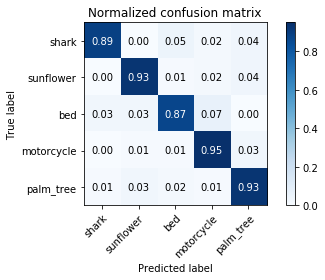

In [5]:
model = cifar_model_builder(model_subtype)(x_train.shape[1:], num_classes)
print(model.summary())

keras_model(model,
            MODELS_DATA_DIR / f'custom_cifar_{model_subtype}_{len(class_names)}_classes_far',
            train=False, train_data=train_test_split(x_train, y_train, test_size=0.1))

y_pred = model.predict_classes(x_test)
y_pred_proba = model.predict_proba(x_test)
print(classification_report(y_test, y_pred, target_names=class_names))

plot_confusion_matrix(y_test, y_pred, classes=np.array(class_names), normalize=True,
                      title='Normalized confusion matrix')


#### Clustering using extracted features

In [6]:
features_layer = layer_functor(model, 'features')
features = features_layer(np.concatenate((x_train, x_test)))

In [7]:
features.shape

(3000, 1024)

*Original labels*

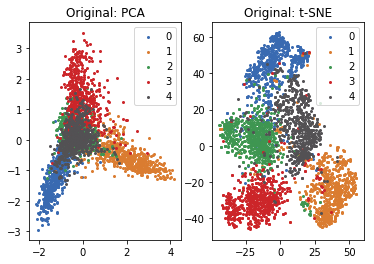

In [8]:
fig, (ax_pca, ax_tsne) = plt.subplots(ncols=2)
y_original = np.concatenate((y_train, y_test))
plot_pca_2d(features, y_original, title=f"Original: PCA", ax=ax_pca)
plot_tsne_2d(features, y_original, title=f"Original: t-SNE", ax=ax_tsne)
plt.show()

*K-Means*

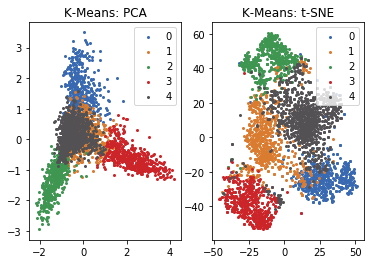

In [9]:
fig, (ax_pca, ax_tsne) = plt.subplots(ncols=2)
kmeans = KMeans(n_clusters=5).fit(features)
y_kmeans = kmeans.predict(features)
plot_pca_2d(features, y_kmeans, title=f"K-Means: PCA", ax=ax_pca)
plot_tsne_2d(features, y_kmeans, title=f"K-Means: t-SNE", ax=ax_tsne)
plt.show()

*LDA: Latent Dirichlet Allocation*

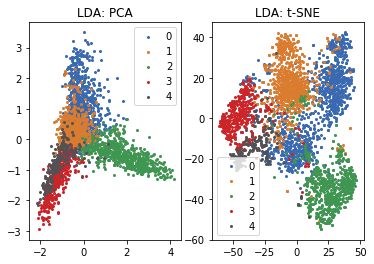

In [11]:
fig, (ax_pca, ax_tsne) = plt.subplots(ncols=2)
lda = LatentDirichletAllocation(n_components=5)
y_lda = lda.fit_transform(features)
y_lda = np.argmax(y_lda, axis=1)
plot_pca_2d(features, y_lda, title=f"LDA: PCA", ax=ax_pca)
plot_tsne_2d(features, y_lda, title=f"LDA: t-SNE", ax=ax_tsne)
plt.show()